# YouTube Watch History Data Analysis

### Introduction

YouTube has become an essential part of many people's daily lives. It serves as a platform for entertainment, learning, and relaxation. This project focuses on analyzing YouTube watch history data to gain insights into viewing patterns and habits.

### Project Goals
The project aims to achieve both general descriptive approaches and more personalized analyses to provide a comprehensive understanding of YouTube usage habits.

In general, I'd like to:

1. **Quantify Viewing Activity**: Determine the total number of videos watched and the total watch hours over the specified period.
2. **Explore Daily Viewing Patterns**: Calculate the average time spent watching YouTube videos each day.
3. **Identify Most Watched Videos**: Determine the most watched videos on the YouTube history data based on the number of views.
4. **Analyze Video Titles**: Extract and analyze the most common keywords in video titles to identify recurring themes.
5. **Discover Peak Viewing Days**: Identify the specific days when the highest number of videos were watched and the number of likes received.
6. **Know the longest timeframe where you haven't used YouTube**.
7. **Find the most viewed, liked, or commented videos watched**.
8. **Show the longest video watched**.
9. **Get to know favorite channels**.
10. **Analyze each tag from videos**.
11. **Analyze the distribution of watch times throughout the day**.
12. **Identify trends in video consumption over different time periods (daily, weekly, monthly)**.

Additionally, I will perform more personalized analysis through my own YouTube History data along the way.


### The source dataset

The dataset for this analysis was created using a two-step process that involved web scraping and API requests to gather comprehensive information about my YouTube watch history.

First, I used a Python script called youtube_scraper.py to extract data from an HTML file of my YouTube History. This HTML file was obtained through Google Takeout, which provides a detailed export of a user's YouTube activity. Using the BeautifulSoup library, the script parsed the HTML file to extract essential information for each video, including the video title, URL, the time it was played, the channel that posted it, and the channel's URL. This information was then saved into a CSV file named history.csv.

However, the HTML file from Google Takeout did not provide all the details I wanted for my analysis. To enrich the dataset with additional information, I created another Python script named youtube_api.py. This script aimed to fill in the gaps by fetching more data through the YouTube Data API. For each video entry in history.csv, the script extracted the video ID from the URL. With the video ID in hand, the script made API requests to gather further details such as the video's duration, the number of likes and dislikes it had received, and the total number of comments. This additional data provided a more comprehensive view of each video that will allow us to perform deeper analysis.

### Extraction Process

1. **Google Takeout**:
    - The initial dataset was downloaded from Google Takeout, which provided an HMTL file containing basic information about each video watched, including the video title, timestamp, link, and channel name.

2. **YouTube API**:
    - Using the video IDs extracted from the Google Takeout dataset, the YouTube Data API was used to retrieve additional information. 
    - A script was written in Python to interact with the YouTube Data API. This script performed the following steps:
        1. **Authenticate**: Connect to the YouTube Data API using an API key.
        2. **Request Data**: For each video ID, send a request to the YouTube API to fetch video details.
        3. **Parse Response**: Extract relevant information from the API response, such as video tags, number of likes, number of comments, and other metadata.
        4. **Merge Data**: Combine the additional information from the YouTube API with the original Google Takeout data to create a more comprehensive dataset and output it in a CSV file.

## Project Structure

- **Data Collection**: Scripts and notebooks for extracting and collecting data from Google Takeout.
- **Data Cleaning**: Steps to clean and preprocess the data to ensure it is ready for analysis.
- **Exploratory Data Analysis**: Notebooks containing analysis and visualizations to uncover insights and trends.
- **Results**: Summary of findings and key takeaways from the analysis.

## How to Use

1. **Clone the Repository**: `git clone https://github.com/your-username/your-repository.git`
2. **Install Dependencies**: `pip install -r requirements.txt`
3. **Run Notebooks**: Open and run the Jupyter Notebooks to reproduce the analysis.

## Requirements

- Python 3.x
- Jupyter Notebook
- pandas
- numpy
- matplotlib
- seaborn

# Before we begin
I'd like to inform you that the results and insights presented here might not fully correspond to realistic viewing habits due to several factors that can affect data integrity. For example, if you use multiple YouTube accounts, the data from just one account might not provide a complete picture. Additionally, there are other scenarios that can potentially impact the results, which I will mention as we go along.

In my case, I only use one YouTube account, so all the videos I've watched are perfectly stored in the dataset. However, I still expect to encounter discrepancies due to other factors.


## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
from wordcloud import WordCloud
from datetime import datetime, timedelta
%matplotlib inline

## Read the dataset on a dataframe

In [2]:
file = 'youtube_data.csv'
df = pd.read_csv(file)

In [3]:
# Let's take a peak at the dataset
df.head(3)

,title,url,video_duration,channel_name,channel_url,date_time,video_date_upload,video_category,video_views,video_likes,video_comment_count,video_description,video_tags
0,"Vivaldi - Concerto No. 4 in F minor, Op. 8, RV...",https://www.youtube.com/watch?v=igYzAdRTd5c,00:09:31,Joshua Galasse,https://www.youtube.com/channel/UCB7LdHQgEM2NG...,"Jun 02, 2024, 11:40:50 PM",2018-08-25 00:57:15,Music,4696406.0,134209.0,1514.0,"Joshua Galasse, Brussels Sinfonietta\nRecorded...","Joshua Galasse,vivaldi,L'inverno,4 seasons,violin"
1,F. Chopin : Nocturne in c sharp minor for viol...,https://www.youtube.com/watch?v=T7k2pmKUXxI,00:04:37,Gemma Violin,https://www.youtube.com/channel/UCMeR1_1ZOcfdG...,"Jun 02, 2024, 11:36:13 PM",2016-01-14 18:58:06,Music,18908196.0,389309.0,7301.0,#chopin #nocturne #violinpiano #version\n\n- C...,"chopin,nocturne,violin,piano,duo,classicalmusi..."
2,Franz Liszt - Liebestraum - Love Dream,https://www.youtube.com/watch?v=KpOtuoHL45Y,00:05:51,The Wicked North,https://www.youtube.com/channel/UC5I_q7gLdDoBn...,"Jun 02, 2024, 11:30:21 PM",2008-10-24 06:12:47,Music,38690876.0,322485.0,11437.0,Liebesträume is a set of three solo piano work...,"Franz,Liszt,Liebestraum,Love,Dream,classical,m..."


In [4]:
df.shape

(1847, 13)

### Interpretation

There are a total of 1847 rows in the dataset each has 13 columns representing each video's categorical attributes.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847 entries, 0 to 1846
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                1847 non-null   object 
 1   url                  1847 non-null   object 
 2   video_duration       1844 non-null   object 
 3   channel_name         1847 non-null   object 
 4   channel_url          1847 non-null   object 
 5   date_time            1847 non-null   object 
 6   video_date_upload    1844 non-null   object 
 7   video_category       1844 non-null   object 
 8   video_views          1844 non-null   float64
 9   video_likes          1844 non-null   float64
 10  video_comment_count  1844 non-null   float64
 11  video_description    1510 non-null   object 
 12  video_tags           1308 non-null   object 
dtypes: float64(3), object(10)
memory usage: 187.7+ KB


### Convert the columns that represent count times as integer(int64)

In [7]:
# proceed on converting float64 elements into an int64 type
int_columns = ['video_views', 'video_likes', 'video_comment_count']

# Convert the specified columns to integer, keeping missing values as NaN
for col in int_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    
# check updated data
df.info()
df.to_csv('youtube_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847 entries, 0 to 1846
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1847 non-null   object
 1   url                  1847 non-null   object
 2   video_duration       1844 non-null   object
 3   channel_name         1847 non-null   object
 4   channel_url          1847 non-null   object
 5   date_time            1847 non-null   object
 6   video_date_upload    1844 non-null   object
 7   video_category       1844 non-null   object
 8   video_views          1844 non-null   Int64 
 9   video_likes          1844 non-null   Int64 
 10  video_comment_count  1844 non-null   Int64 
 11  video_description    1510 non-null   object
 12  video_tags           1308 non-null   object
dtypes: Int64(3), object(10)
memory usage: 193.1+ KB


Only columns for video description, comment count, and tags are optionally allowed to be empty, as some videos don't have any of them. It seems there are missing values in some rows because there is an inconsistency in the non-null count in the table above. This means our API script has failed to return further information on these specific videos. From my investigation, these videos have been removed or deleted on YouTube, which is why the YouTube API can't retrieve information such as like counts.

The missing data is not due to an error in our data extraction process but rather reflects changes on the YouTube platform. It is common for YouTube videos to be removed or made private by the uploader over time. Unfortunately, this means that we won't be able to include these videos in our analysis. However, even if we drop them, we will still include them in the total video watched count.

In [12]:
# check for total misisng values for each column in dataframe
df.isna().sum()

title                    0
url                      0
video_duration           3
channel_name             0
channel_url              0
date_time                0
video_date_upload        3
video_category           3
video_views              3
video_likes              3
video_comment_count      3
video_description      337
video_tags             539
dtype: int64

In [14]:
# Drop rows with more than two null values.
df.dropna(axis=0, thresh=len(df.columns) - 2, inplace=True)

df.to_csv('youtube_data.csv', index=False)

In [15]:
df.reset_index(drop=True, inplace=True)

Moving forward, we will proceed with the remaining data, ensuring that only valid and relevant entries are included in our analysis. This step is crucial to maintaining the integrity and accuracy of our results.

## Check for duplicate values

It is expected that there might be some duplicates since I have watched similar videos. However, the duplicates we are concerned with are those where every value in the row is identical that indicates a true duplicate record.

Let's check if there is.

In [22]:
duplicated = df[df.duplicated(keep=False)]
print("There are {} duplicated rows.".format(len(duplicated)))

There are 0 duplicated rows.


### Let's try to get more insights to spot discrepancies in the data

In [24]:
# Set the display option to show the full numerical values
pd.set_option('display.float_format', '{:.2f}'.format)

# display full numerical values
df.describe()

,video_views,video_likes,video_comment_count
count,1844.00,1844.00,1844.00
mean,23085394.09,489706.05,8020.03
std,92565986.97,1526365.10,57320.82
min,9.00,0.00,0.00
25%,440013.00,9787.25,283.00
50%,3937933.00,77593.50,1727.00
75%,18324309.00,317084.00,7114.00
max,1793508392.00,18853862.00,2341878.00


## Exploratory Data Analysis

Now that we've standardized and cleaned the data to ensure its accuracy and consistency, it's time to begin into an exploratory data analysis (EDA) to extract meaningful insights from our YouTube history.

In this section, we will explore various aspects of the data to gain a better understanding. Specifically, we will:

Explore Descriptive Analysis

1. **Determine the start-date and end-date**
2. **Determine the number of videos watched for each week given the timeframe**
3. **Determine the specific days when the most videos were watched**
4. **Calculate the average video watched per day**
5. **Identify the top 10 most viewed video watched on YouTube in my history from the past three months**
6. **Plot the ratio between regular YouTube videos and YouTube shorts**
7. **Determine the average watch of regular YouTube videos and YouTube shorts per day**
8. **Determine the most favorite YouTube Videos by the number of times they were watched and by each month.** 
9. **Identify the most common keyword or substring on all video titles, tags, and description**
10. **Identify the most favorite channels**
11. **Determine the longest timeframe when you haven't watched on YouTube**
12. **Identify the Oldest Video uploaded on YouTube in your watch history**
13. **Discover the most liked and most commented videos on YouTube in your watch history**
14. **Find out youtube videos which where posted the same day as your birthday**
15. **Determine the videos with the longest duration**

Personalized analysis
1. **What time do you often watch on YouTube?**
2. **What day of the week do you often watch on YouTube?**




## Determine the start date and end date

In [26]:
# The YouTube data is sorted in date from newest to oldest
start_date = df.iloc[-1]['date_time']
end_date = df.iloc[0]['date_time']

print("Start date: ", start_date)
print("End date: ", end_date)

Start date:  Feb 20, 2024, 06:17:15 AM
End date:  Jun 02, 2024, 11:40:50 PM


## Determine the number of videos watched for each week

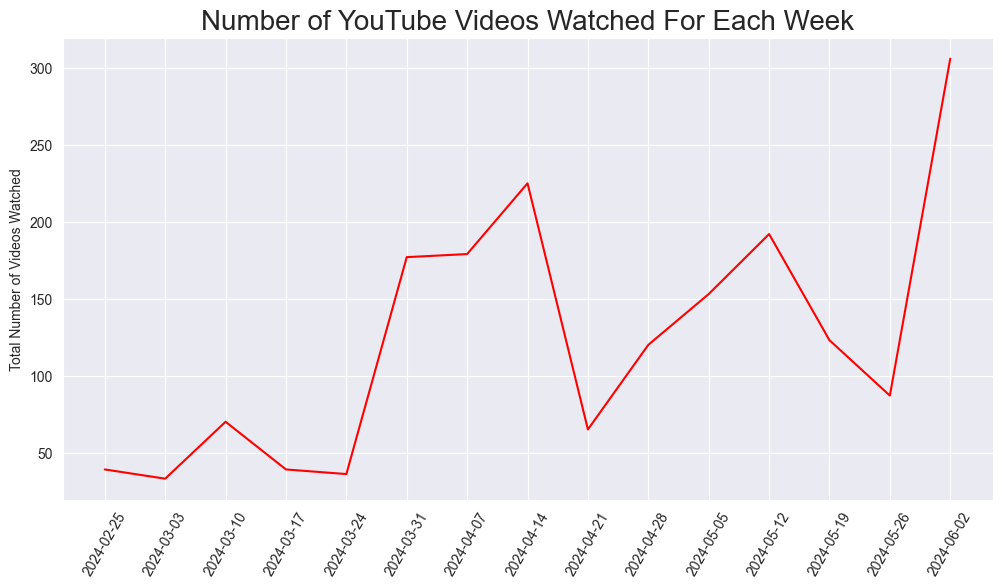

In [109]:
import matplotlib.dates as mdates
# Sort from oldest to newest
df_sorted = df.sort_values(by='date_time')

df_sorted['date_time'] = pd.to_datetime(df_sorted['date_time'])

# Set the 'date_time' column as the index
df_sorted.set_index('date_time', inplace=True)

# Resample the data by week and count the occurrences
weekly_counts = df_sorted.resample('W').size()
# Reset the index to make the 'date_time' column again
weekly_counts = weekly_counts.reset_index(name='frequency')
# Display the result
# Extract week numbers and frequencies for plotting
weekly_counts['week_number'] = weekly_counts['date_time'].dt.isocalendar().week
weeks = weekly_counts['week_number']
dates = weekly_counts['date_time'].astype('str')
videos = weekly_counts['frequency']

# Customize the graph to show
plt.figure(figsize=(12, 6), facecolor='white')
plt.title('Number of YouTube Videos Watched For Each Week', size=20)
plt.ylabel('Total Number of Videos Watched')
plt.xticks(rotation=60)
# Plot as a bar chart
plt.plot(dates, videos, color='red')
plt.show()

## Determine the specific days when the most videos were watched (regardless of whether some videos were re-watched)

In [119]:
# Sort from oldest to newest
df_sorted = df.sort_values(by='date_time')

df_sorted['date_time'] = pd.to_datetime(df_sorted['date_time'])

# Set the 'date_time' column as the index
df_sorted.set_index('date_time', inplace=True)
# Resample the data by dat and count the occurrences
daily_counts = df_sorted.resample('D').size()
# Reset the index to make the 'date_time' column again
daily_counts = daily_counts.reset_index(name='frequency')

daily_counts.sort_values('frequency', ascending=False)[:5]


,date_time,frequency
99,2024-05-29,171
43,2024-04-03,76
36,2024-03-27,58
101,2024-05-31,56
51,2024-04-11,55


## Calculate the average watch per day

In [126]:
print(f"The average number of videos watched per day from February 20 to June 02, 2024, is {round(daily_counts['frequency'].mean())} videos.")

The average number of videos watched per day from February 20 to June 02, 2024, is 18 videos.


## Identify the top 10 most viewed video watched on YouTube in my history from the past three months

Excluding YouTube Shorts or technically short videos

In [136]:
# Apply condition to filter the rows
condition = ((df_sorted['title'].str.contains('#shorts', case=False)) |
             (pd.to_timedelta(df_sorted['video_duration']).dt.total_seconds() <= 61))

# Only include the YouTube Regular Videos, negate the condition
filtered_df = df_sorted[~condition].reset_index(drop=True)
filtered_df = filtered_df.drop_duplicates(subset='title', keep='first')
filtered_df.sort_values('video_views', ascending=False)[['title', 'video_views']][:10]

,title,video_views
160,4 Non Blondes - What's Up (Official Music Video),1793508392
164,In The End [Official HD Music Video] - Linkin ...,1785079284
514,Rick Astley - Never Gonna Give You Up (Officia...,1546359981
163,Evanescence - Bring Me To Life (Official HD Mu...,1380041318
705,BLACKPINK - '뚜두뚜두 (DDU-DU DDU-DU)' DANCE PRACT...,501677991
161,The Cranberries - Linger (Official Music Video),467786407
704,BLACKPINK - '붐바야(BOOMBAYAH)' DANCE PRACTICE VIDEO,313076452
1100,Four Seasons ~ Vivaldi,259340236
545,The Best of Mozart,259311782
788,Michael Bublé - Feeling Good [Official 4K Rema...,250843011


## Plot the ratio between regular YouTube videos and YouTube shorts

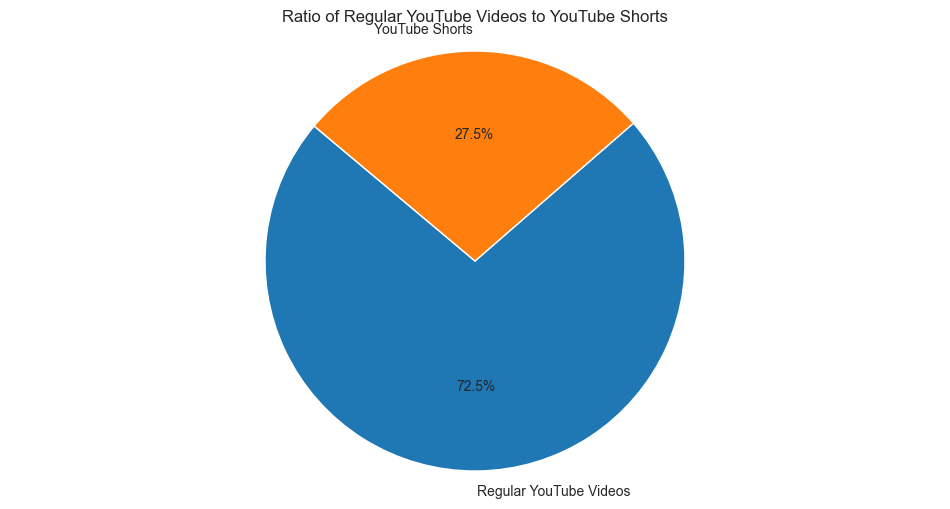

In [137]:
normal_or_shorts = df[['title', 'video_duration']]

video_shorts_count = ((df['title'].str.contains('#shorts', case=False)) |
         (pd.to_timedelta(df['video_duration']).dt.total_seconds() <= 61)).sum()

video_normal_count = normal_or_shorts.shape[0] - video_shorts_count

counts = [video_normal_count, video_shorts_count]
# Create a pie chart
plt.figure(figsize=(12, 6))
plt.pie(counts, labels=['Regular YouTube Videos', 'YouTube Shorts'], autopct='%1.1f%%', startangle=140)
plt.title('Ratio of Regular YouTube Videos to YouTube Shorts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()